<a href="https://colab.research.google.com/github/PatriciaSojcakova/Zneus_project/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Projekt 1***

---

In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from argparse import Namespace
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        confusion_matrix,
        roc_auc_score,
        ConfusionMatrixDisplay
    )
import wandb

# **1. Prieskumná analýza dát**

## **1.1 Analýza štruktúr dát**
Dataset pozostáva zo súboru `speeddating.csv`, ktorý obsahuje informácie o osobách a ich preferencie o potenciálnych partneroch. Súbor obsahuje 8378 záznamov, 123 atribútov typov int64 a object.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_1/speeddating.csv')

/tmp/ipython-input-1521480062.py:1: DtypeWarning: Columns (3,10,11,15,16,17,18,19,39,40,41,42,43,44,51,52,53,54,55,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,107,109) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_1/speeddating.csv')


In [ ]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 123 columns):
 #    Column                           Dtype 
---   ------                           ----- 
 0    has_null                         int64 
 1    wave                             int64 
 2    gender                           object
 3    age                              object
 4    age_o                            object
 5    d_age                            int64 
 6    d_d_age                          object
 7    race                             object
 8    race_o                           object
 9    samerace                         int64 
 10   importance_same_race             object
 11   importance_same_religion         object
 12   d_importance_same_race           object
 13   d_importance_same_religion       object
 14   field                            object
 15   pref_o_attractive                object
 16   pref_o_sincere                   object
 17   pref_o_intel

#### **Výber vhodných atribútov**

V nasledujúcej časti sme riešili redukciu atribútov datasetu, a teda výber tých atribútov, ktoré budú vstupovať do predikčného modelu.

Tento výber sme realizovali najmä na základe korelačných vzťahov medzi atribútmi a predikovanou premennou "match" resp. tiež premennými "decision" a "decision_o", nakoľko tieto premenné priamo súvisia s výsledkom speeddatu.

Zároveň sme pri výbere zohľadnili aj osobný pohľad na relevantnosť atribútov, ktorú sme usúdili z popisu datasetu a významu jednotlivých atribútov.

Pretypovanie numerických atribútov na numerický dátový typ, aby sme mohli sledovať korelácie.

In [ ]:
data_new = data.copy()

skip_cols = ['has_null','gender', 'race', 'race_o', 'field']


for col in data_new.columns:
  if data_new[col].dtype == 'object' and not col.startswith('d_') and col not in skip_cols:
    data_new[col] = pd.to_numeric(data_new[col], errors='coerce')

data_new.info(verbose=True)
corr_matrix_all = data_new.corr(method='pearson', numeric_only=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 123 columns):
 #    Column                           Dtype  
---   ------                           -----  
 0    has_null                         int64  
 1    wave                             int64  
 2    gender                           object 
 3    age                              float64
 4    age_o                            float64
 5    d_age                            int64  
 6    d_d_age                          object 
 7    race                             object 
 8    race_o                           object 
 9    samerace                         int64  
 10   importance_same_race             float64
 11   importance_same_religion         float64
 12   d_importance_same_race           object 
 13   d_importance_same_religion       object 
 14   field                            object 
 15   pref_o_attractive                float64
 16   pref_o_sincere                   float64

Zobrazenie korelácií medzi atribútmi a predikovanou premennou.

In [ ]:
pd.set_option('display.max_rows', None)

corr_decision = corr_matrix_all['decision'].sort_values(ascending=False)
corr_decision_o = corr_matrix_all['decision_o'].sort_values(ascending=False)
corr_match = corr_matrix_all['match'].sort_values(ascending=False)


print("Korelácia s 'decision':")
display(corr_decision)

print("\nKorelácia s 'decision_o':")
display(corr_decision_o)

print("\nKorelácia s 'match':")
display(corr_match)

Korelácia s 'decision':


,decision
decision,1.000000
match,0.521943
like,0.513463
attractive_partner,0.486775
funny_partner,0.414477
shared_interests_partner,0.400644
guess_prob_liked,0.310861
expected_num_matches,0.229232
intelligence_partner,0.217313
sincere_partner,0.209994



Korelácia s 'decision_o':


,decision_o
decision_o,1.000000
match,0.522326
attractive_o,0.486885
funny_o,0.414276
shared_interests_o,0.400501
intelligence_o,0.216704
sinsere_o,0.209811
ambitous_o,0.183216
guess_prob_liked,0.150767
expected_num_interested_in_me,0.111123



Korelácia s 'match':


,match
match,1.000000
decision_o,0.522326
decision,0.521943
like,0.305723
funny_o,0.277700
funny_partner,0.277545
shared_interests_o,0.270840
shared_interests_partner,0.270679
attractive_o,0.260837
attractive_partner,0.260676


Výber vhodných atribútov pre predikčný model.

Výber bol realizovaný na základe korelácií, pričom najsilnejšie korelácie mali atribúty, ktoré hovoria, ako sa navzájom subjekty hodnotia vrámci určitých vlastností. Taktiež sa tu nachádzajú atribúty, ktoré hovoria o vzájomnej podobnosti osobných záujmov. Samozrejme ešte základné atribúty pohlavia, veku, rasy.

In [ ]:
cols = ['gender', 'age', 'age_o', 'd_age','samerace', 'importance_same_race', 'importance_same_religion',
        'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o','shared_interests_o',
        'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner','shared_interests_partner',
        'interests_correlate', 'expected_num_matches','expected_num_interested_in_me','like', 'met', 'match']
data = data[cols].copy()

data.head()

,gender,age,age_o,d_age,samerace,importance_same_race,importance_same_religion,attractive_o,sinsere_o,intelligence_o,...,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_num_matches,expected_num_interested_in_me,like,met,match
0,female,21,27,6,0,2,4,6,8,8,...,7,7,6,5,0.14,4,2,7,0,0
1,female,21,22,1,0,2,4,7,8,10,...,7,8,5,6,0.54,4,2,7,1,0
2,female,21,22,1,1,2,4,10,10,10,...,9,8,5,7,0.16,4,2,7,1,1
3,female,21,23,2,0,2,4,7,8,9,...,8,7,6,8,0.61,4,2,7,0,1
4,female,21,24,3,0,2,4,8,7,9,...,7,7,6,6,0.21,4,2,6,0,1


## **1.2 Čistenie dát**


### **1.2.A Identifikácia a odstránenie duplikátov**

In [ ]:
print("Duplicity v dátach:", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Duplicity po odstránení:", data.duplicated().sum())

Duplicity v dátach: 1
Duplicity po odstránení: 0


Dataset obsahoval 1 duplicitný záznam. Tento záznam sme odstránili.

### **1.2.B Identifikácia chýbajúcich hodnôt a ich nahradenie**
Zistili sme, že namiesto hodnoty NaN alebo null sa v datasete objavuje "?". Pre lepši manipuláciu s dátami sme túto hodnotu nahradili hodnotov NaN.

In [ ]:
print('------------ Počet výskytov "?" v stĺpcoch ------------')
for col in data.columns:
    print(f"{col}: {(data[col] == '?').sum()}")

------------ Počet výskytov "?" v stĺpcoch ------------
gender: 0
age: 94
age_o: 104
d_age: 0
samerace: 0
importance_same_race: 78
importance_same_religion: 78
attractive_o: 211
sinsere_o: 286
intelligence_o: 305
funny_o: 359
ambitous_o: 721
shared_interests_o: 1075
attractive_partner: 201
sincere_partner: 276
intelligence_partner: 295
funny_partner: 349
ambition_partner: 711
shared_interests_partner: 1066
interests_correlate: 157
expected_num_matches: 1172
expected_num_interested_in_me: 6577
like: 239
met: 374
match: 0


In [ ]:
data.replace('?', np.nan, inplace=True)
print(data.isnull().sum())

gender                              0
age                                94
age_o                             104
d_age                               0
samerace                            0
importance_same_race               78
importance_same_religion           78
attractive_o                      211
sinsere_o                         286
intelligence_o                    305
funny_o                           359
ambitous_o                        721
shared_interests_o               1075
attractive_partner                201
sincere_partner                   276
intelligence_partner              295
funny_partner                     349
ambition_partner                  711
shared_interests_partner         1066
interests_correlate               157
expected_num_matches             1172
expected_num_interested_in_me    6577
like                              239
met                               374
match                               0
dtype: int64


Chýbajúce hodnoty veku bolo možné medzi atribútmi veku dopočítať. Preto sme to realizovali aby sme zbytočne tieto záznamy nestratili.

In [ ]:
for col in ['age', 'age_o', 'd_age']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

mask_age_missing = data['age'].isna() & data['age_o'].notna() & data['d_age'].notna()
data.loc[mask_age_missing, 'age'] = data.loc[mask_age_missing, 'd_age'] + data.loc[mask_age_missing, 'age_o']


mask_age_o_missing = data['age_o'].isna() & data['age'].notna() & data['d_age'].notna()
data.loc[mask_age_o_missing, 'age_o'] = data.loc[mask_age_o_missing, 'age'] - data.loc[mask_age_o_missing, 'd_age']


print(data[['age','age_o','d_age']].isna().sum())

age      1
age_o    1
d_age    0
dtype: int64


Pri ostatných numerických záznamoch sme chýbajúce hodnoty nahradili priemerom.

In [ ]:
skip_cols = ['gender', 'age', 'age_o', 'd_age', 'samerace', 'met', 'match']

for col in data.columns:
    if col not in skip_cols:
        data[col] = pd.to_numeric(data[col], errors='coerce')

        if pd.api.types.is_numeric_dtype(data[col]):
            mean_value = data[col].mean()
            data[col] = data[col].fillna(mean_value)

print("Počet chýbajúcich hodnôt po nahradení priemerom:")
print(data.isnull().sum())

Počet chýbajúcich hodnôt po nahradení priemerom:
gender                             0
age                                1
age_o                              1
d_age                              0
samerace                           0
importance_same_race               0
importance_same_religion           0
attractive_o                       0
sinsere_o                          0
intelligence_o                     0
funny_o                            0
ambitous_o                         0
shared_interests_o                 0
attractive_partner                 0
sincere_partner                    0
intelligence_partner               0
funny_partner                      0
ambition_partner                   0
shared_interests_partner           0
interests_correlate                0
expected_num_matches               0
expected_num_interested_in_me      0
like                               0
met                              374
match                              0
dtype: int64


Zvyšné záznamy s chýbajúcimi hodnotami sme odstránili, nakoľko ich počet nebol príliš vysoký. Po ich odstránení ostalo presne 8002 záznamov pre predikčný model.

In [ ]:
data = data.dropna()
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8002 entries, 0 to 8377
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         8002 non-null   object 
 1   age                            8002 non-null   float64
 2   age_o                          8002 non-null   float64
 3   d_age                          8002 non-null   int64  
 4   samerace                       8002 non-null   int64  
 5   importance_same_race           8002 non-null   float64
 6   importance_same_religion       8002 non-null   float64
 7   attractive_o                   8002 non-null   float64
 8   sinsere_o                      8002 non-null   float64
 9   intelligence_o                 8002 non-null   float64
 10  funny_o                        8002 non-null   float64
 11  ambitous_o                     8002 non-null   float64
 12  shared_interests_o             8002 non-null   float6

### **1.2.C Oprava dátových typov dát**
Atribúty, kde sa nachádzajú iba čísla, sme pretypovali na numerický dátový typ.

In [ ]:
for col in data.columns:
  if (col not in ["gender"]) :
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8002 entries, 0 to 8377
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         8002 non-null   object 
 1   age                            8002 non-null   float64
 2   age_o                          8002 non-null   float64
 3   d_age                          8002 non-null   int64  
 4   samerace                       8002 non-null   int64  
 5   importance_same_race           8002 non-null   float64
 6   importance_same_religion       8002 non-null   float64
 7   attractive_o                   8002 non-null   float64
 8   sinsere_o                      8002 non-null   float64
 9   intelligence_o                 8002 non-null   float64
 10  funny_o                        8002 non-null   float64
 11  ambitous_o                     8002 non-null   float64
 12  shared_interests_o             8002 non-null   float6

In [ ]:
data.head()

,gender,age,age_o,d_age,samerace,importance_same_race,importance_same_religion,attractive_o,sinsere_o,intelligence_o,...,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_num_matches,expected_num_interested_in_me,like,met,match
0,female,21.0,27.0,6,0,2.0,4.0,6.0,8.0,8.0,...,7.0,7.0,6.0,5.0,0.14,4.0,2.0,7.0,0,0
1,female,21.0,22.0,1,0,2.0,4.0,7.0,8.0,10.0,...,7.0,8.0,5.0,6.0,0.54,4.0,2.0,7.0,1,0
2,female,21.0,22.0,1,1,2.0,4.0,10.0,10.0,10.0,...,9.0,8.0,5.0,7.0,0.16,4.0,2.0,7.0,1,1
3,female,21.0,23.0,2,0,2.0,4.0,7.0,8.0,9.0,...,8.0,7.0,6.0,8.0,0.61,4.0,2.0,7.0,0,1
4,female,21.0,24.0,3,0,2.0,4.0,8.0,7.0,9.0,...,7.0,7.0,6.0,6.0,0.21,4.0,2.0,6.0,0,1


### **1.2.D Identifikácia odľahlých hodnôt**

V nasledujúcej časti bolo potrebné detekovať, vyhodnotiť a následne odstrániť nelogicky odľahlé hodnoty.

Odľahlé hodnoty sme detekovali vo všetkých numerických atribútoch.

In [ ]:
outliers_cols = ['attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
                  'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner',
                  'interests_correlate','like','importance_same_race', 'importance_same_religion','shared_interests_partner','shared_interests_o']

Najskôr sme si vykreslili boxploty atribútov, kde sme sledovali či sú všetky hodnoty atribútov vrámci ich očakávaných intervalov.

Očakávané intervaly sú pri atribúte "interests_correlate" [-1,1], pri všetkých ostatných atribútoch [0,10].

Rozhodli sme sa odľahlé hodnoty identifikovať práve na základe týchto intervalov a nie pomocou medód ako IQR, keďže pri použití takejto metódy by sme zbytožne prišli o veľa záznamov. Taktiež je použitie týchto metód v našom prípade nelogické, pretože ide o atribúty osobného hodnotenia subjektov. Preto nemôžeme považovať skutočnosť, že niekto ohodnotil, povedzme humor, hodnotou 0 za outlier.

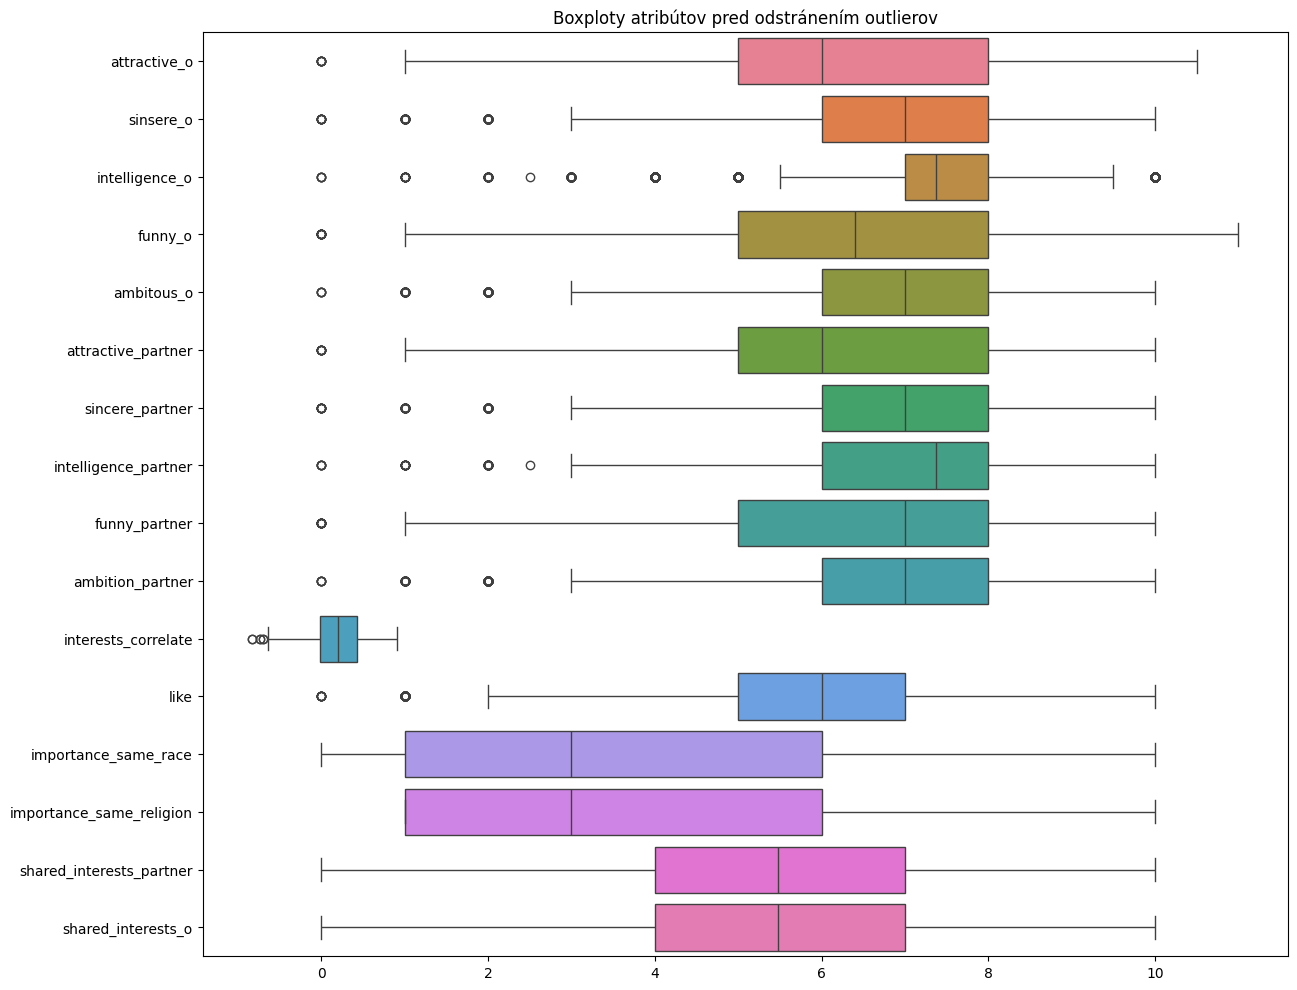

In [ ]:
plt.figure(figsize=(14, len(outliers_cols) * 0.75))
sns.boxplot(data=data[outliers_cols], orient='h')
plt.title("Boxploty atribútov pred odstránením outlierov")
plt.show()

Z boxplotov je zrejmé, že niektoré hodnoty sú nelogicky mimo očakávaného rozsahu, preto sme všetky atribúty skontrolovali a v prípade potreby tieto hodnoty odstránili.

In [ ]:
for col in outliers_cols:
    if col == 'interests_correlate':
        low, high = -1, 1
    else:
        low, high = 0, 10

    mask_out = (data[col] < low) | (data[col] > high)
    count_out = mask_out.sum()

    if count_out > 0:
        print(f"{col}: {count_out} mimo rozsahu – odstránené.")
        data = data[~mask_out]
    else:
        print(f"{col}: OK ")

data.reset_index(drop=True, inplace=True)

attractive_o: 1 mimo rozsahu – odstránené.
sinsere_o: OK 
intelligence_o: OK 
funny_o: 1 mimo rozsahu – odstránené.
ambitous_o: OK 
attractive_partner: OK 
sincere_partner: OK 
intelligence_partner: OK 
funny_partner: OK 
ambition_partner: OK 
interests_correlate: OK 
like: OK 
importance_same_race: OK 
importance_same_religion: OK 
shared_interests_partner: OK 
shared_interests_o: OK 


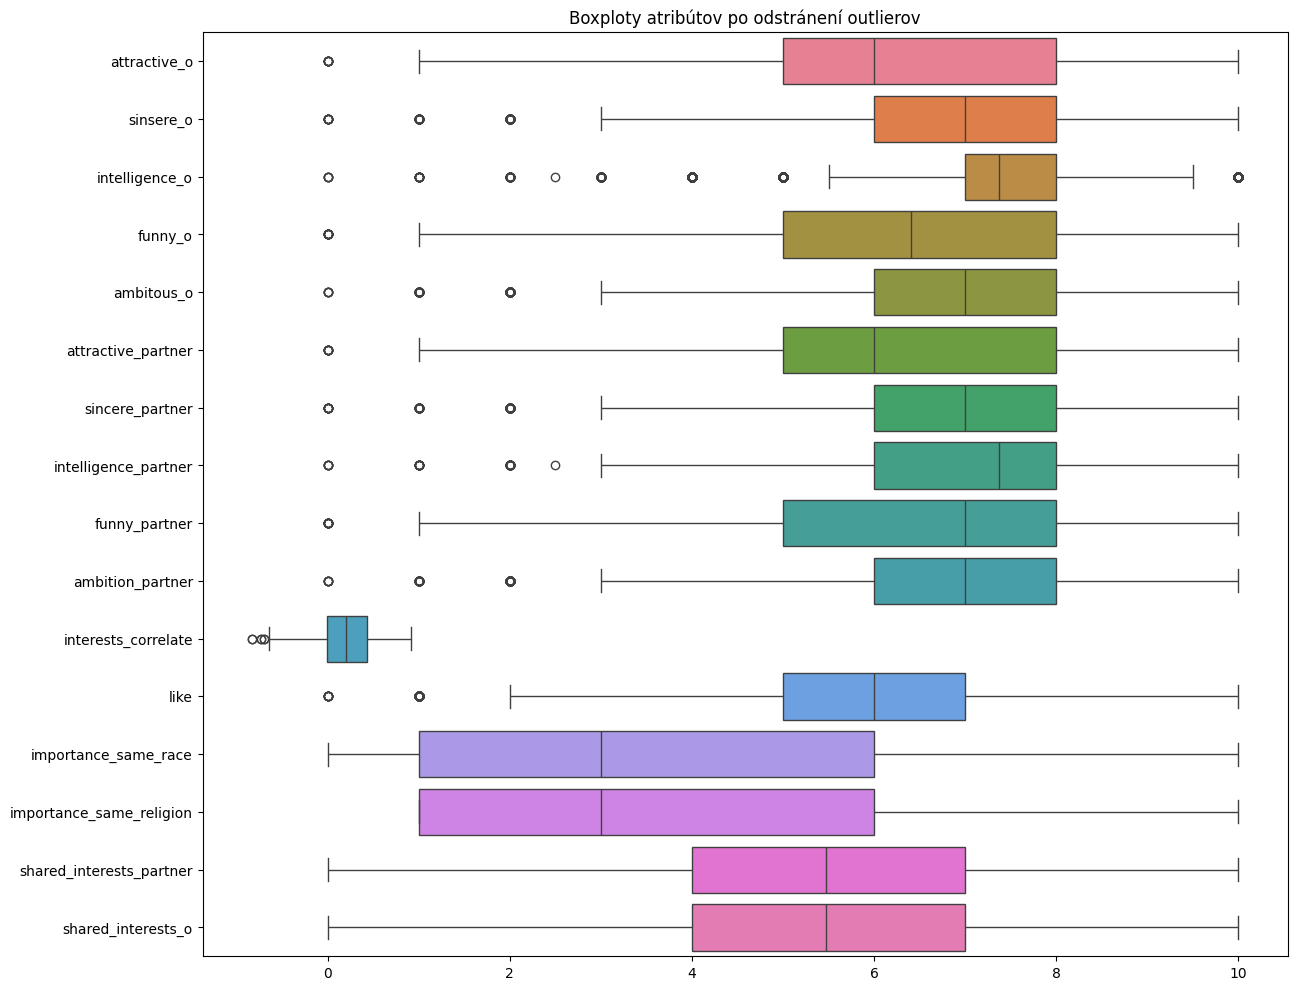

In [ ]:
plt.figure(figsize=(14, len(outliers_cols) * 0.75))
sns.boxplot(data=data[outliers_cols], orient='h')
plt.title("Boxploty atribútov po odstránení outlierov")
plt.show()

Po odstránení outlierov nám ostalo presne 8000 záznamov.

In [ ]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         8000 non-null   object 
 1   age                            8000 non-null   float64
 2   age_o                          8000 non-null   float64
 3   d_age                          8000 non-null   int64  
 4   samerace                       8000 non-null   int64  
 5   importance_same_race           8000 non-null   float64
 6   importance_same_religion       8000 non-null   float64
 7   attractive_o                   8000 non-null   float64
 8   sinsere_o                      8000 non-null   float64
 9   intelligence_o                 8000 non-null   float64
 10  funny_o                        8000 non-null   float64
 11  ambitous_o                     8000 non-null   float64
 12  shared_interests_o             8000 non-null   f

## **1.3 Analýza vybraných atribútov**

V nasledujúcej časti sme analyzovali vybrané atribúty. Vykonali sme nad nimi deskriptívne štatistiky, zobrazili ich distribúcie v podobe grafov a zobrazili ich vzájomné korelácie pomocou korelačnej matice.

Vykonanie základných deskriptívnych štatistík nad numerickými atribútmi:




In [ ]:
numeric_columns = data.select_dtypes(include=['int64','float64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

for col in numeric_columns:
  display(data[col].describe())
  print("-" * 30)

,age
count,8000.000000
mean,26.623125
std,4.529311
min,18.000000
25%,24.000000
50%,26.000000
75%,28.000000
max,74.000000


------------------------------


,age_o
count,8000.000000
mean,26.069375
std,4.491724
min,0.000000
25%,24.000000
50%,26.000000
75%,28.000000
max,55.000000


------------------------------


,d_age
count,8000.000000
mean,4.140750
std,4.486363
min,0.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,37.000000


------------------------------


,samerace
count,8000.000000
mean,0.397625
std,0.489438
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


------------------------------


,importance_same_race
count,8000.000000
mean,3.779867
std,2.822179
min,0.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,10.000000


------------------------------


,importance_same_religion
count,8000.000000
mean,3.672327
std,2.798043
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,10.000000


------------------------------


,attractive_o
count,8000.000000
mean,6.196219
std,1.938436
min,0.000000
25%,5.000000
50%,6.000000
75%,8.000000
max,10.000000


------------------------------


,sinsere_o
count,8000.000000
mean,7.175558
std,1.722391
min,0.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,10.000000


------------------------------


,intelligence_o
count,8000.000000
mean,7.375614
std,1.530419
min,0.000000
25%,7.000000
50%,7.369301
75%,8.000000
max,10.000000


------------------------------


,funny_o
count,8000.000000
mean,6.395366
std,1.930318
min,0.000000
25%,5.000000
50%,6.400599
75%,8.000000
max,10.000000


------------------------------


,ambitous_o
count,8000.000000
mean,6.780580
std,1.726628
min,0.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,10.000000


------------------------------


,shared_interests_o
count,8000.000000
mean,5.471766
std,2.030235
min,0.000000
25%,4.000000
50%,5.474870
75%,7.000000
max,10.000000


------------------------------


,attractive_partner
count,8000.000000
mean,6.189072
std,1.949858
min,0.000000
25%,5.000000
50%,6.000000
75%,8.000000
max,10.000000


------------------------------


,sincere_partner
count,8000.000000
mean,7.176449
std,1.731858
min,0.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,10.000000


------------------------------


,intelligence_partner
count,8000.000000
mean,7.370631
std,1.538430
min,0.000000
25%,6.000000
50%,7.368597
75%,8.000000
max,10.000000


------------------------------


,funny_partner
count,8000.000000
mean,6.397837
std,1.933787
min,0.000000
25%,5.000000
50%,7.000000
75%,8.000000
max,10.000000


------------------------------


,ambition_partner
count,8000.000000
mean,6.777074
std,1.737780
min,0.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,10.000000


------------------------------


,shared_interests_partner
count,8000.000000
mean,5.471218
std,2.038024
min,0.000000
25%,4.000000
50%,5.474559
75%,7.000000
max,10.000000


------------------------------


,interests_correlate
count,8000.000000
mean,0.194627
std,0.301834
min,-0.830000
25%,-0.010000
50%,0.200000
75%,0.430000
max,0.910000


------------------------------


,expected_num_matches
count,8000.000000
mean,3.207848
std,2.267649
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,18.000000


------------------------------


,expected_num_interested_in_me
count,8000.000000
mean,5.571301
std,2.231728
min,0.000000
25%,5.570556
50%,5.570556
75%,5.570556
max,20.000000


------------------------------


,like
count,8000.000000
mean,6.131599
std,1.836444
min,0.000000
25%,5.000000
50%,6.000000
75%,7.000000
max,10.000000


------------------------------


,met
count,8000.000000
mean,0.049750
std,0.282019
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,8.000000


------------------------------


,match
count,8000.000000
mean,0.168250
std,0.374112
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


------------------------------


Grafické zobrazenie vybraných atribútov:

---



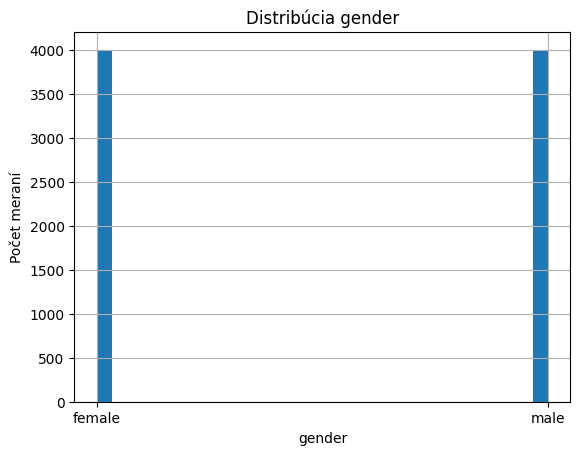

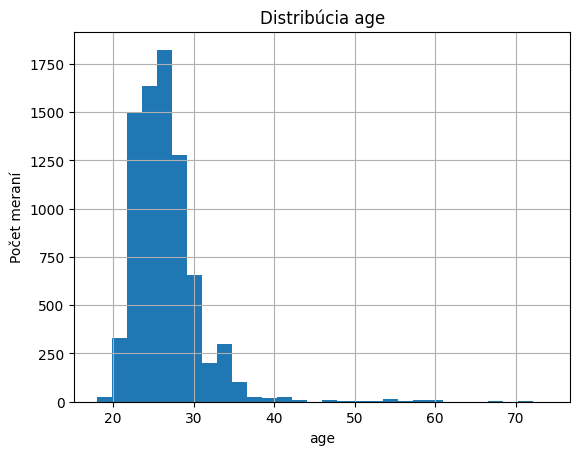

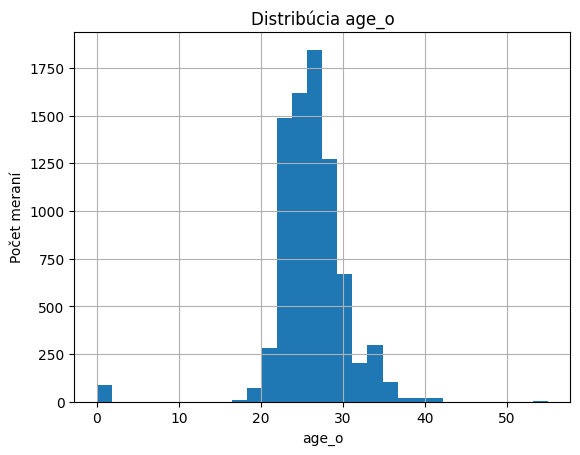

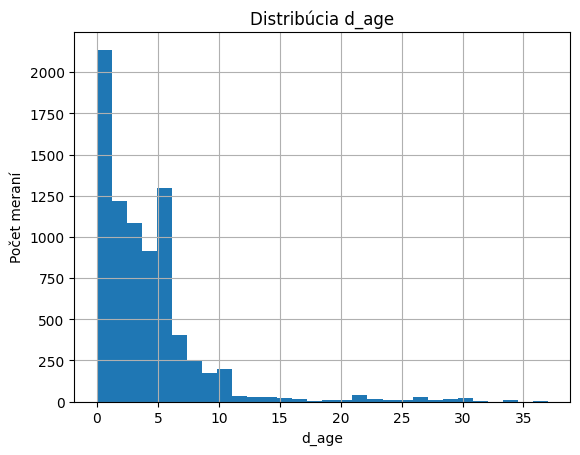

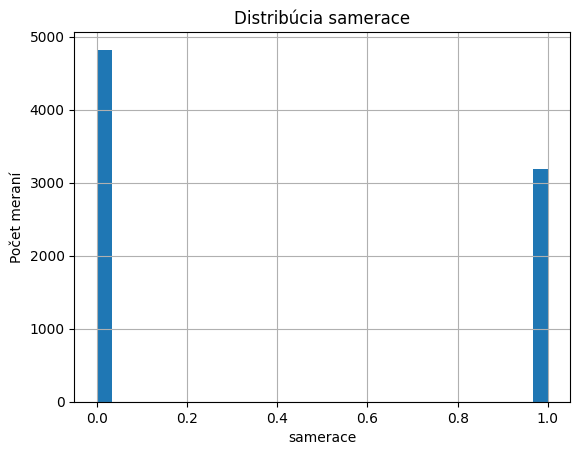

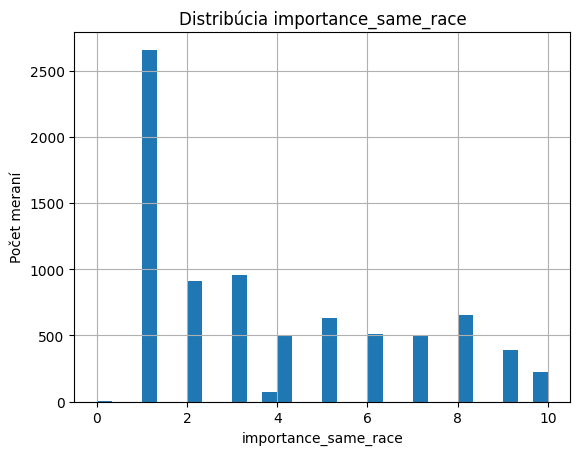

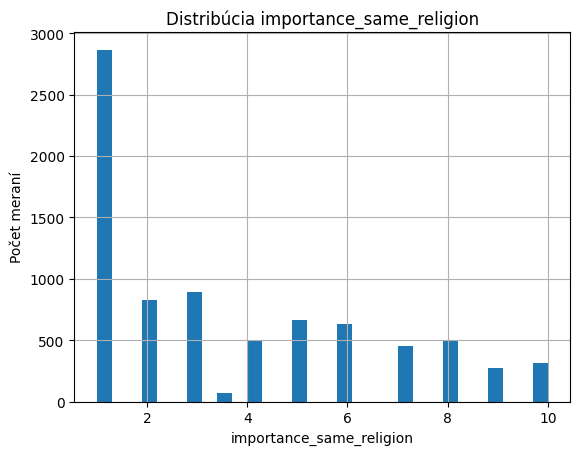

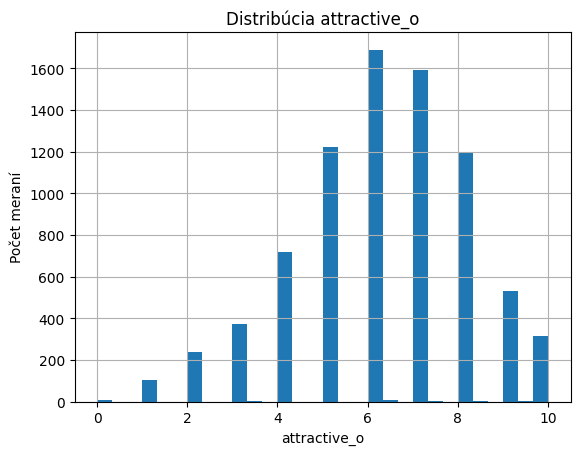

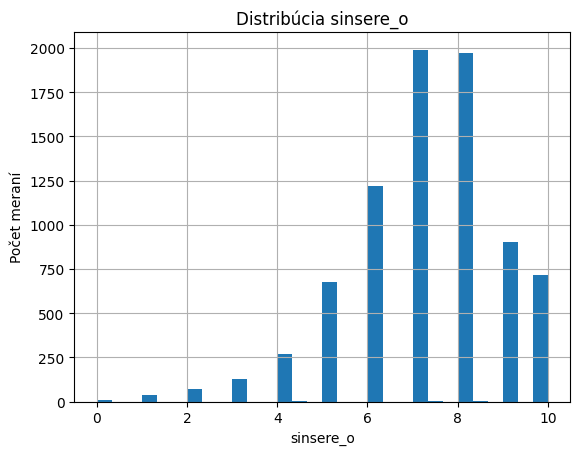

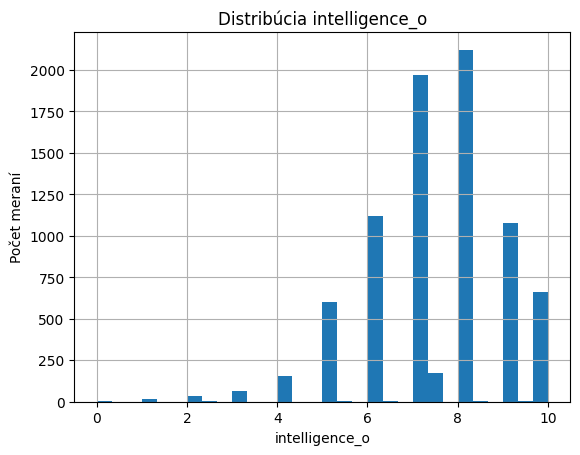

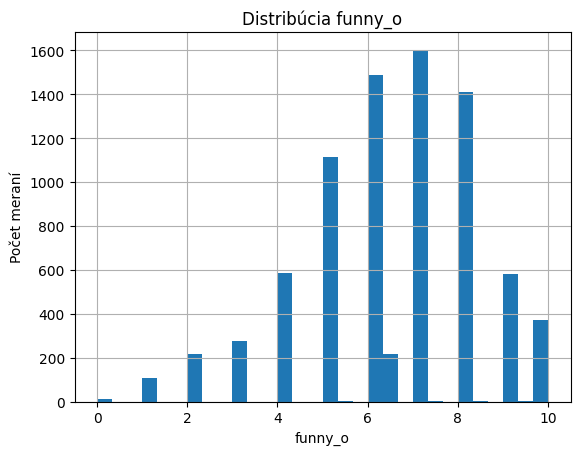

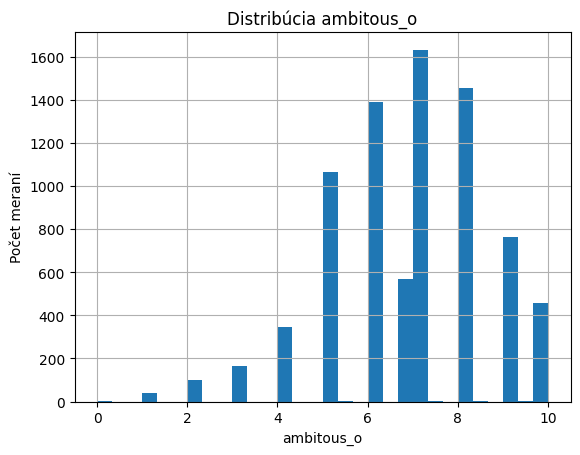

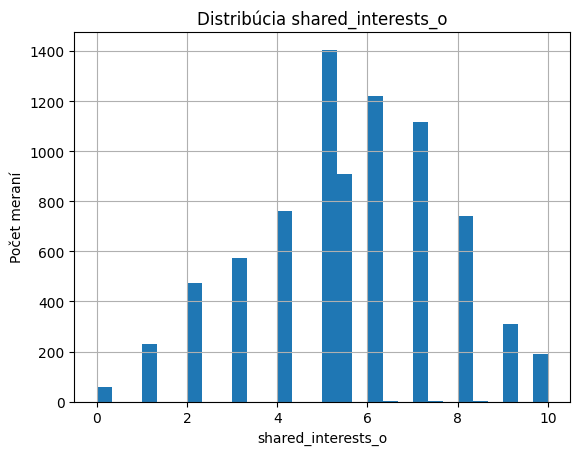

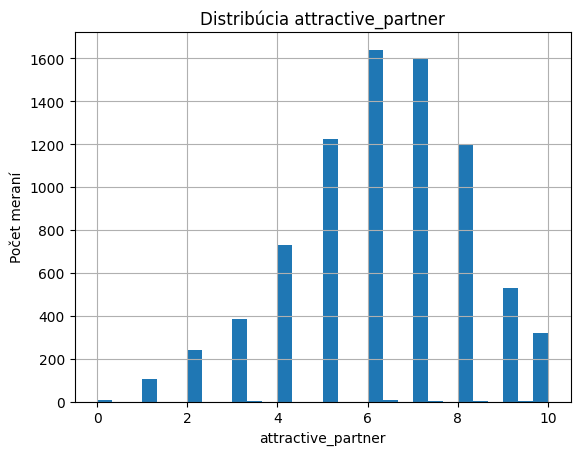

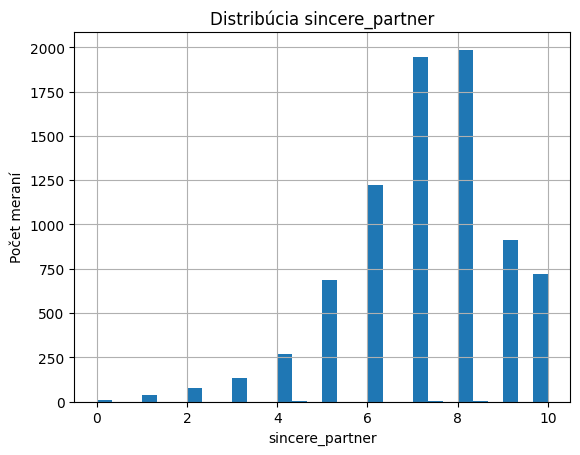

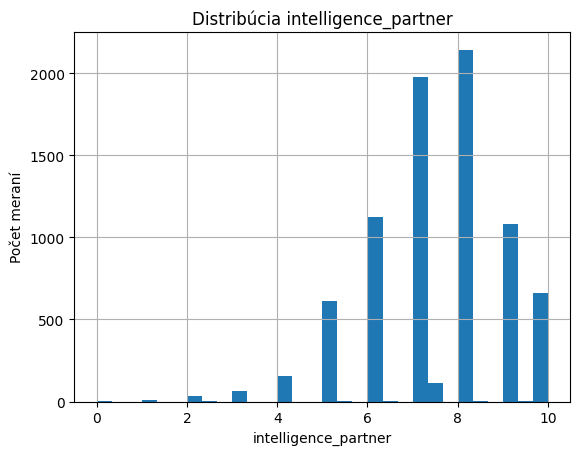

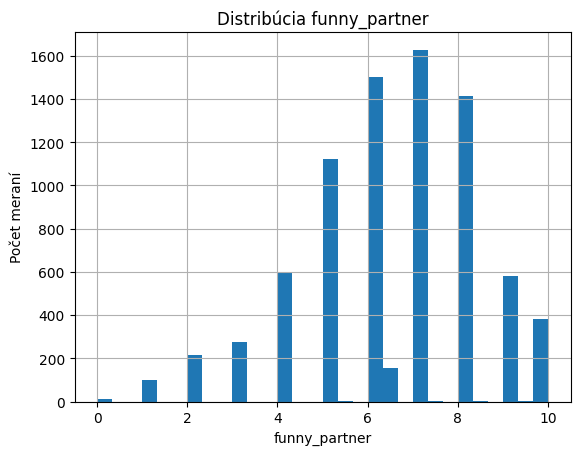

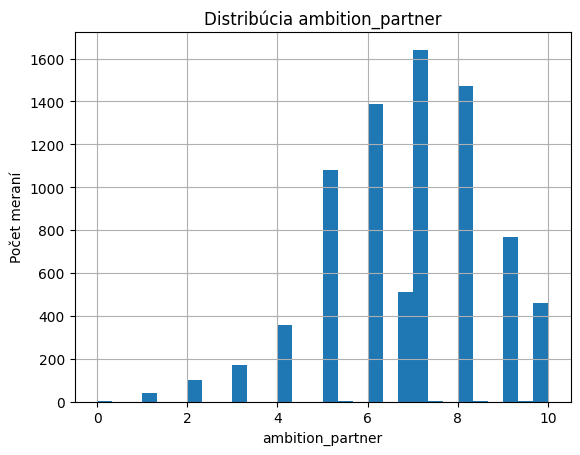

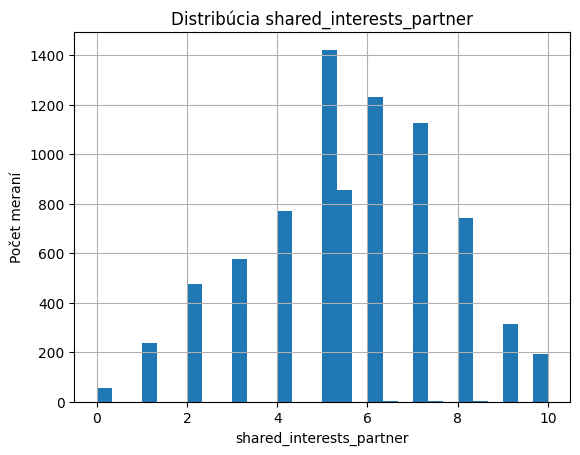

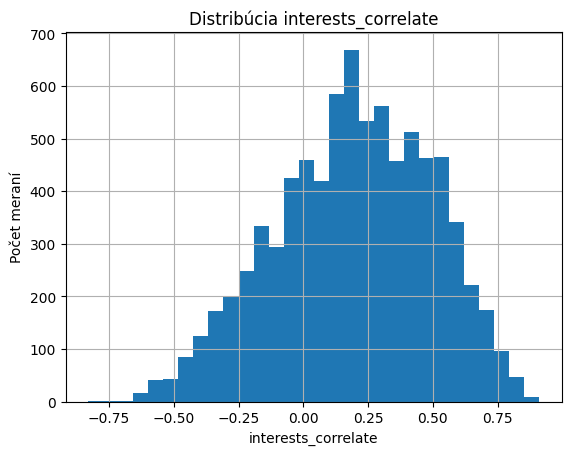

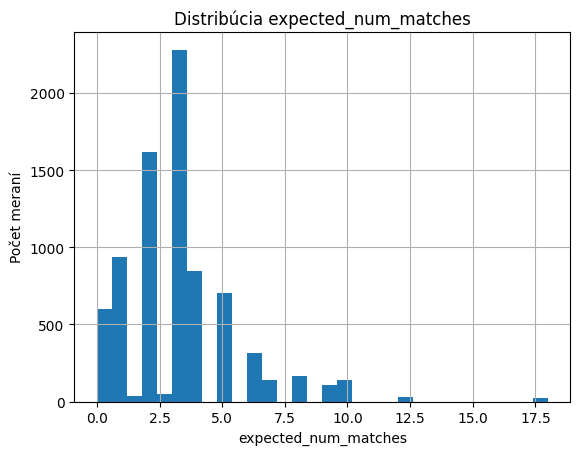

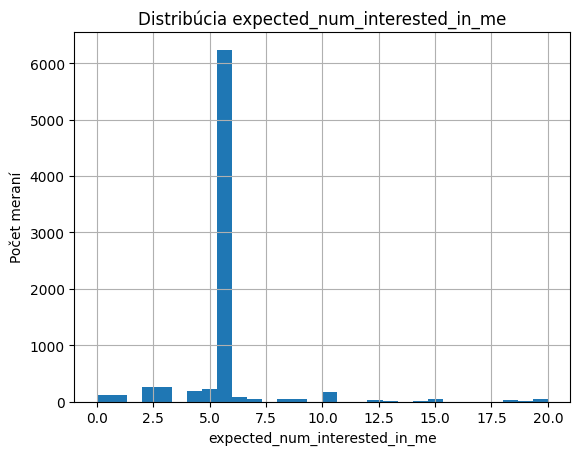

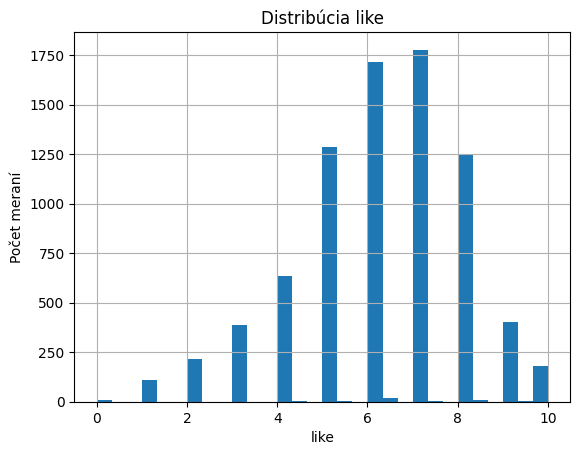

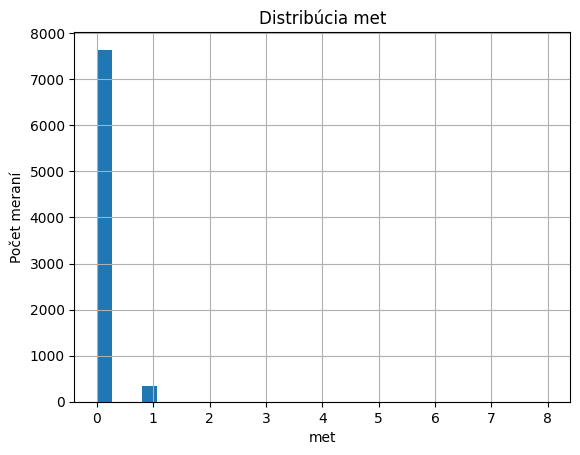

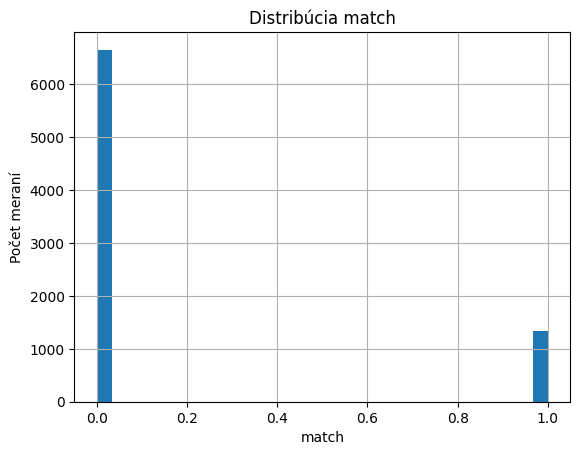

In [ ]:
for col in cols:
    plt.figure()
    data[col].hist(bins=30)
    plt.title(f"Distribúcia {col}")
    plt.xlabel(col)
    plt.ylabel("Počet meraní")
    plt.show()

Zobrazenie korelácii pomocou korelačnej matice na základe Pearsonovho korelačného koeficientu.

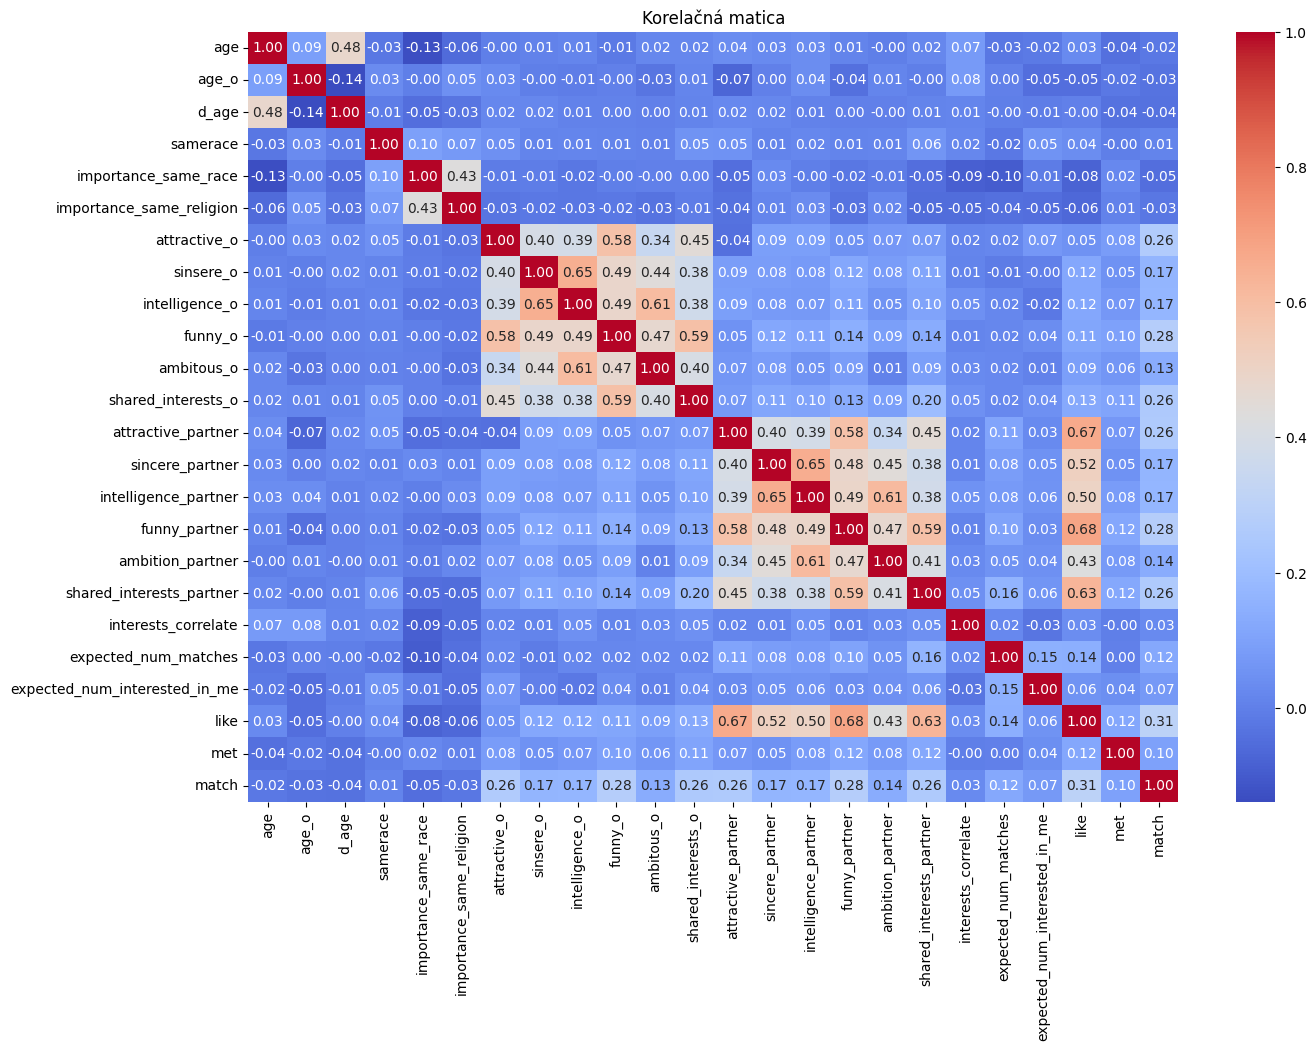

In [ ]:
corr_matrix = data[numeric_columns].corr(method='pearson')
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelačná matica")
plt.show()

## **1.4 Hypotézy**

Formulácia hypotézy:

- H₀ (nulová hypotéza): Medzi hodnotením atraktivity partnera a výsledkom „match“ neexistuje štatisticky významný rozdiel.

- H₁ (alternatívna hypotéza): Úspešné „matchnutie“ je spojené s vyšším hodnotením atraktivity partnera.

Dáta sme rozdelili na dve skupiny podľa premenné match. Skontrolovali sme normalitu a rovnosť variancií — ani jedna zo skupín nespĺňala predpoklady normality (p < 0.05), preto sme použili Mann–Whitney U test.
Po vykonaní testu sme zistili, že zamietame nulovú hypotézu H₀ — rozdiel medzi skupinami je štatisticky významný (p < 0.05).
Vyššia hodnota „atraktivity partnera“ teda zvyšuje pravdepodobnosť, že sa dvaja účastníci „matchnú“.

In [ ]:
group_0 = data[data['match'] == 0]['attractive_partner'].dropna().astype(float)
group_1 = data[data['match'] == 1]['attractive_partner'].dropna().astype(float)


k2_0 = stats.normaltest(group_0)
k2_1 = stats.normaltest(group_1)

print("D’Agostino K² test normality pre attractive_partner:")
print(f"match = 0 → p-hodnota: {k2_0.pvalue}")
print(f"match = 1 → p-hodnota: {k2_1.pvalue}")

levene_test = stats.levene(group_0, group_1)
print(f"\nLeveneho test rovnosti variancií: p-hodnota = {levene_test.pvalue}")

u_stat, p_value = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"\nMann–Whitney U test: p-hodnota = {p_value}")

if p_value < 0.05:
    print("Rozdiel medzi skupinami je štatisticky významný (p < 0.05).")
    print("Zamietame H₀ → Atraktivita partnera ovplyvňuje pravdepodobnosť matchu.")
else:
    print("Rozdiel medzi skupinami nie je štatisticky významný (p ≥ 0.05).")
    print("Nezamietame H₀ → Atraktivita partnera neovplyvňuje match.")

D’Agostino K² test normality pre attractive_partner:
match = 0 → p-hodnota: 3.9409941916530926e-17
match = 1 → p-hodnota: 1.755995017831995e-14

Leveneho test rovnosti variancií: p-hodnota = 1.3409847580071468e-13

Mann–Whitney U test: p-hodnota = 2.2300435777024792e-128
Rozdiel medzi skupinami je štatisticky významný (p < 0.05).
Zamietame H₀ → Atraktivita partnera ovplyvňuje pravdepodobnosť matchu.


# **2. Preprocessing dát**

## **2.1 Encoding**

Naše dáta obsahujú kategorickú premennú gender. Keďže predikčný model nedokáže s atribútmi tohto typu pracovať bolo potrebné ju zakódovať do číselných hodnôt (1/0).

In [ ]:
data = pd.get_dummies(data, columns=['gender'], drop_first=True)
data['gender_male'] = data['gender_male'].astype(int)


In [ ]:
data.head(10)

,age,age_o,d_age,samerace,importance_same_race,importance_same_religion,attractive_o,sinsere_o,intelligence_o,funny_o,...,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_num_matches,expected_num_interested_in_me,like,met,match,gender_male
0,21.0,27.0,6,0,2.0,4.0,6.0,8.0,8.0,8.0,...,7.0,6.0,5.0,0.14,4.0,2.0,7.0,0,0,0
1,21.0,22.0,1,0,2.0,4.0,7.0,8.0,10.0,7.0,...,8.0,5.0,6.0,0.54,4.0,2.0,7.0,1,0,0
2,21.0,22.0,1,1,2.0,4.0,10.0,10.0,10.0,10.0,...,8.0,5.0,7.0,0.16,4.0,2.0,7.0,1,1,0
3,21.0,23.0,2,0,2.0,4.0,7.0,8.0,9.0,8.0,...,7.0,6.0,8.0,0.61,4.0,2.0,7.0,0,1,0
4,21.0,24.0,3,0,2.0,4.0,8.0,7.0,9.0,6.0,...,7.0,6.0,6.0,0.21,4.0,2.0,6.0,0,1,0
5,21.0,25.0,4,0,2.0,4.0,7.0,7.0,8.0,8.0,...,4.0,6.0,4.0,0.25,4.0,2.0,6.0,0,0,0
6,21.0,30.0,9,0,2.0,4.0,3.0,6.0,7.0,5.0,...,4.0,6.0,7.0,0.34,4.0,2.0,6.0,0,0,0
7,21.0,28.0,7,0,2.0,4.0,7.0,7.0,8.0,8.0,...,9.0,8.0,8.0,0.28,4.0,2.0,7.0,0,1,0
8,21.0,24.0,3,0,2.0,4.0,6.0,6.0,6.0,6.0,...,8.0,10.0,8.0,-0.36,4.0,2.0,6.0,0,0,0
9,24.0,27.0,3,1,2.0,5.0,8.0,7.0,6.0,9.0,...,4.0,6.0,3.0,0.29,3.0,5.0,6.0,0,0,0


## **2.2 Rozdelenie dát**

Rozdelenie datasetu na trénovaciu, validačnú a testovaciu množinu, pričom bol zachovaný pomer match:unmatch vo všetkých množinách.

In [ ]:
X = data.drop(columns=['match'])
y = data['match']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,
    random_state=42,
    stratify=y_temp
)

print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f} %)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f} %)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f} %)")


Train: 5599 (70.0 %)
Validation: 1201 (15.0 %)
Test: 1200 (15.0 %)


## **2.3 Normalizácia dát**

Pre atribúty "age", "age_o" a "d_age" bola použitá metóda MinMaxScaler zo scikit-learn, ktorá škáluje hodnoty do intervalu [0, 1] na základe rozsahu hodnôt v tréningových dátach.

Ostatné numerické atribúty, ktorých hodnoty sú v rozsahu [0, 10], boli normalizované jednoduchým delením hodnoty 10.

Atribút "interests_correlate", ktorý nadobúda hodnoty z intervalu [-1, 1], bol transformovaný na rozsah [0, 1] pomocou vzorca:

  x_new (x_old +1)/2

In [ ]:
scale_cols = ['age', 'age_o', 'd_age']

scaler = MinMaxScaler()

X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_val[scale_cols] = scaler.transform(X_val[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

In [ ]:
normalize_cols = [
    'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
    'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner',
    'ambition_partner', 'importance_same_race', 'importance_same_religion',
    'shared_interests_partner', 'shared_interests_o', 'like']

corr_col = 'interests_correlate'

X_train[normalize_cols] = X_train[normalize_cols] / 10
X_val[normalize_cols] = X_val[normalize_cols] / 10
X_test[normalize_cols] = X_test[normalize_cols] / 10

X_train[corr_col] = (X_train[corr_col] + 1) / 2
X_val[corr_col] = (X_val[corr_col] + 1) / 2
X_test[corr_col] = (X_test[corr_col] + 1) / 2

Výpis ukazuje formu dát po rozdelení a normalizácii. Vidíme, že v trénovacej, validačnej aj testovacej množine je zachovaný rovnaký pomer match:unmatch

In [ ]:
print("Tvar tréningových dát:", X_train.shape)
print("Tvar validačných dát:", X_val.shape)
print("Tvar testovacích dát:", X_test.shape)
print("Pomer tried v trénovacej množine:\n", y_train.value_counts(normalize=True))
print("Pomer tried vo validačnej množine:\n", y_val.value_counts(normalize=True))
print("Pomer tried v testovacej množine:\n", y_test.value_counts(normalize=True))

Tvar tréningových dát: (5599, 24)
Tvar validačných dát: (1201, 24)
Tvar testovacích dát: (1200, 24)
Pomer tried v trénovacej množine:
 match
0    0.831756
1    0.168244
Name: proportion, dtype: float64
Pomer tried vo validačnej množine:
 match
0    0.831807
1    0.168193
Name: proportion, dtype: float64
Pomer tried v testovacej množine:
 match
0    0.831667
1    0.168333
Name: proportion, dtype: float64


#**3. Analýza pomocou LDA**

Linear Discriminant Analysis (LDA) je štatistická metóda používaná na zníženie dimenzionality dát pri zachovaní čo najlepšej separácie medzi triedami.  
V tomto kroku aplikujeme LDA na trénovaciu množinu, aby sme:

- zistili, ako dobre sa dajú triedy oddeliť pomocou existujúcich atribútov,  
- vizualizovali ich projekciu v jednorozmernom alebo dvojrozmernom priestore



LDA: reduced shape (5599, 1)


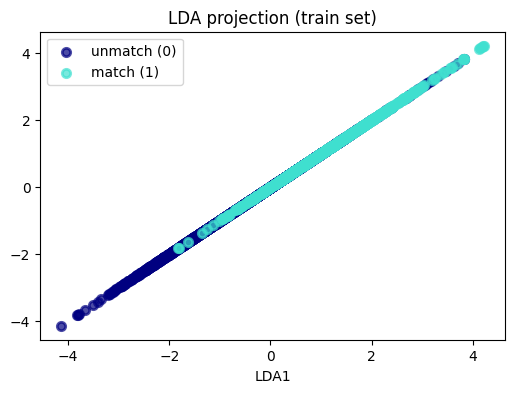

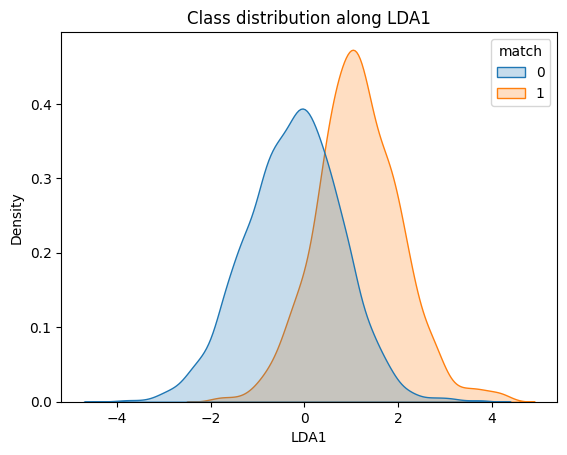

In [ ]:
def plot_reduced_dataset(X_r, y, fig_title):
    plt.figure(figsize=(6,4))
    colors = ['navy', 'turquoise']
    lw = 2
    target_names = ['unmatch (0)', 'match (1)']


    for color, i, target_name in zip(colors, [0, 1], target_names):
        plt.scatter(
            X_r[y == i, 0],
            X_r[y == i, 0 if X_r.shape[1] == 1 else 1],
            color=color,
            alpha=0.7,
            lw=lw,
            label=target_name
        )

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(fig_title)
    plt.xlabel("LDA1")
    plt.ylabel("LDA2" if X_r.shape[1] > 1 else "")
    plt.show()


X_numeric = X_train.select_dtypes(include=['int64', 'float64'])
y_numeric = y_train

lda = LinearDiscriminantAnalysis(n_components=1)   # redukcia na 1D
X_lda = lda.fit(X_numeric, y_numeric).transform(X_numeric)

print('LDA: reduced shape', X_lda.shape)

plot_reduced_dataset(X_lda, y_numeric.values, "LDA projection (train set)")

df_plot = pd.DataFrame({'LDA1': X_lda[:, 0], 'match': y_numeric.values})
sns.kdeplot(data=df_plot, x='LDA1', hue='match', fill=True, common_norm=False)
plt.title("Class distribution along LDA1")
plt.show()


Na základe grafov vidíme, že triedy match (1) a unmatch (0) sú čiastočne oddeliteľné pozdĺž prvej diskriminačnej osi (LDA1). To hovorí, že existuje lineárny vzťah medzi vstupnými atribútmi a výsledkom „match“.

#**4. Predikčný model**

## **4.1 Architektúra modelu**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, cfg):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in cfg.hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            if cfg.use_batchnorm:
                layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(cfg.dropout_rate))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, 1))
        #layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## **4.2 Data handling**

In [ ]:
class DataModule:
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, batch_size, num_workers):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.batch_size = batch_size
        self.num_workers = num_workers

    def _to_tensor(self, X, y):
        X_tensor = torch.tensor(X.values, dtype=torch.float32)
        y_tensor = torch.tensor(y.to_numpy().reshape(-1, 1), dtype=torch.float32)
        return X_tensor, y_tensor

    def setup(self):
        X_train_tensor, y_train_tensor = self._to_tensor(self.X_train, self.y_train)
        X_val_tensor, y_val_tensor = self._to_tensor(self.X_val, self.y_val)
        self.X_test_tensor, self.y_test_tensor = self._to_tensor(self.X_test, self.y_test)

        self.train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        self.val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

## **4.3 Trénovanie validácia a testovanie modelu**

In [ ]:
class Trainer:
    def __init__(self, model, data_module, cfg):
        self.model = model
        self.data_module = data_module
        self.cfg = cfg

        self.train_loader = data_module.train_dataloader()
        self.val_loader = data_module.val_dataloader()

        self.pos_weight = torch.tensor([cfg.pos_weight])
        self.loss_function = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        self.optimizer = optim.Adam(self.model.parameters(), lr=cfg.learning_rate)

    def train_epoch(self):
        self.model.train()
        train_loss = []
        correct = 0
        total = 0

        for X_batch, y_batch in self.train_loader:
            self.optimizer.zero_grad()
            prediction = self.model(X_batch)
            loss = self.loss_function(prediction, y_batch)
            loss.backward()
            self.optimizer.step()
            train_loss.append(loss.item())

            preds = (torch.sigmoid(prediction) > 0.55).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        epoch_loss = np.mean(train_loss)
        epoch_acc = correct / total
        return epoch_loss, epoch_acc

    def validate(self):
        self.model.eval()
        val_loss = []
        val_correct = 0
        val_total = 0

        y_val_true = []
        y_val_pred = []
        y_val_proba = []

        with torch.no_grad():
            for X_val_batch, y_val_batch in self.val_loader:
                val_pred = self.model(X_val_batch)
                v_loss = self.loss_function(val_pred, y_val_batch)
                val_loss.append(v_loss.item())

                v_proba = torch.sigmoid(val_pred)
                v_preds = (v_proba > 0.55).float()

                y_val_true.extend(y_val_batch.cpu().numpy().ravel())
                y_val_pred.extend(v_preds.cpu().numpy().ravel())
                y_val_proba.extend(v_proba.cpu().numpy().ravel())

                val_correct += (v_preds == y_val_batch).sum().item()
                val_total += y_val_batch.size(0)

        val_epoch_loss = np.mean(val_loss)
        val_epoch_acc = val_correct / val_total
        val_epoch_f1 = f1_score(y_val_true, y_val_pred)
        try:
            val_epoch_rocauc = roc_auc_score(y_val_true, y_val_proba)
        except ValueError:
            val_epoch_rocauc = float('nan')

        cm = confusion_matrix(y_val_true, y_val_pred)
        return val_epoch_loss, val_epoch_acc, val_epoch_f1, val_epoch_rocauc, cm

    def test(self):
        self.model.eval()
        with torch.no_grad():
            X_test = self.data_module.X_test_tensor
            y_test = self.data_module.y_test_tensor

            outputs = self.model(X_test)
            preds = (torch.sigmoid(outputs) > 0.55).float()
            accuracy = (preds == y_test).sum().item() / y_test.size(0)
            print(f"Test Accuracy: {accuracy:.4f}")
            #wandb.log({"test_acc": accuracy})   # kvoli experiment trackingu

    def fit(self):
        for epoch in range(self.cfg.max_epochs):
            epoch_loss, epoch_acc = self.train_epoch()
            val_loss, val_acc, val_f1, val_rocauc, cm = self.validate()

            #kvoli experiment trackingu

            '''wandb.log({
                "train_loss": epoch_loss,
                "train_acc": epoch_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_f1": val_f1,
                "val_roc_auc": val_rocauc,
                "epoch": epoch + 1
            })'''

            print(f"Epoch {epoch+1}/{self.cfg.max_epochs} - "
                  f"Training Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
                  f"Validation Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, "
                  f"F1: {val_f1:.4f}, ROC-AUC: {val_rocauc:.4f}")
            print(f"Confusion Matrix:\n{cm}\n")


In [ ]:
cfg = Namespace(
    batch_size = 128,
    num_workers = 2,
    max_epochs = 30,
    learning_rate = 0.0005,
    hidden_dims = [128, 64, 16],
    dropout_rate = 0.3,
    use_batchnorm = True,
    pos_weight = 2)


In [ ]:
#kvoli experiment trackingu
'''wandb.init(
    project="MLP_classification_project",
    name="exp_lr{}_drop{}".format(cfg.learning_rate, cfg.dropout_rate),
    config={
        "learning_rate": cfg.learning_rate,
        "batch_size": cfg.batch_size,
        "epochs": cfg.max_epochs,
        "optimizer": "Adam",
        "loss_function": "BCEWithLogitsLoss",
        "pos_weight": cfg.pos_weight,
        "model": "MLP",
        "dropout": cfg.dropout_rate,
        "hidden_dims": cfg.hidden_dims,
        "use_batchnorm": cfg.use_batchnorm
    }
)'''

'wandb.init(\n    project="MLP_classification_project",\n    name="exp_lr{}_drop{}".format(cfg.learning_rate, cfg.dropout_rate),\n    config={\n        "learning_rate": cfg.learning_rate,\n        "batch_size": cfg.batch_size,\n        "epochs": cfg.max_epochs,\n        "optimizer": "Adam",\n        "loss_function": "BCEWithLogitsLoss",\n        "pos_weight": cfg.pos_weight,\n        "model": "MLP",\n        "dropout": cfg.dropout_rate,\n        "hidden_dims": cfg.hidden_dims,\n        "use_batchnorm": cfg.use_batchnorm\n    }\n)'

In [ ]:
data_module = DataModule(X_train, y_train, X_val, y_val, X_test, y_test,
                         batch_size=cfg.batch_size, num_workers=cfg.num_workers)
data_module.setup()

input_dim = X_train.shape[1]
model = MLP(input_dim, cfg)

trainer = Trainer(model, data_module, cfg)
trainer.fit()
trainer.test()

Epoch 1/30 - Training Loss: 0.8013, Acc: 0.7073 | Validation Loss: 0.7654, Acc: 0.7694, F1: 0.4144, ROC-AUC: 0.7542
Confusion Matrix:
[[826 173]
 [104  98]]

Epoch 2/30 - Training Loss: 0.7260, Acc: 0.7723 | Validation Loss: 0.7025, Acc: 0.7810, F1: 0.4600, ROC-AUC: 0.7870
Confusion Matrix:
[[826 173]
 [ 90 112]]

Epoch 3/30 - Training Loss: 0.6771, Acc: 0.7864 | Validation Loss: 0.6567, Acc: 0.7852, F1: 0.4756, ROC-AUC: 0.7983
Confusion Matrix:
[[826 173]
 [ 85 117]]

Epoch 4/30 - Training Loss: 0.6393, Acc: 0.8080 | Validation Loss: 0.6246, Acc: 0.7885, F1: 0.4730, ROC-AUC: 0.8074
Confusion Matrix:
[[833 166]
 [ 88 114]]

Epoch 5/30 - Training Loss: 0.6184, Acc: 0.8103 | Validation Loss: 0.6021, Acc: 0.8010, F1: 0.4816, ROC-AUC: 0.8134
Confusion Matrix:
[[851 148]
 [ 91 111]]

Epoch 6/30 - Training Loss: 0.5945, Acc: 0.8146 | Validation Loss: 0.5783, Acc: 0.8102, F1: 0.4771, ROC-AUC: 0.8137
Confusion Matrix:
[[869 130]
 [ 98 104]]

Epoch 7/30 - Training Loss: 0.5767, Acc: 0.8241 | Va

In [ ]:
#kvoli experiment trackingu

'''torch.save(model.state_dict(), "model_final.pt")
wandb.save("model_final.pt")

wandb.finish()'''

'torch.save(model.state_dict(), "model_final.pt")\nwandb.save("model_final.pt")\n\nwandb.finish()'

## **4.4 Experimentovanie - Sweep**

In [ ]:
'''def train(X_train, y_train, X_val, y_val, X_test, y_test):
    import os
    os.environ["WANDB_SILENT"] = "true"

    wandb.init()
    cfg = Namespace(
        batch_size = wandb.config.get("batch_size", 64),
        num_workers = wandb.config.get("num_workers", 2),
        max_epochs = wandb.config.get("max_epochs", 50),
        learning_rate = wandb.config.get("learning_rate", 0.001),
        hidden_dims = wandb.config.get("hidden_dims", [128, 64, 32]),
        dropout_rate = wandb.config.get("dropout_rate", 0.3),
        use_batchnorm = wandb.config.get("use_batchnorm", True),
        pos_weight = wandb.config.get("pos_weight", 1.0)
    )

    data_module = DataModule(X_train, y_train, X_val, y_val, X_test, y_test,
                             batch_size=cfg.batch_size, num_workers=cfg.num_workers)
    data_module.setup()
    input_dim = X_train.shape[1]
    model = MLP(input_dim, cfg)
    trainer = Trainer(model, data_module, cfg)
    trainer.fit()
    trainer.test()


sweep_config = {
    "method": "grid",
    "metric": {"goal": "maximize", "name": "val_roc_auc"},
    "parameters": {
        "batch_size": {"values": [32, 64, 128]},
        "dropout_rate": {"values": [0.3, 0.5]},
        "learning_rate": {"values": [0.001, 0.0005, 0.0001]},
        "max_epochs": {"values": [30, 50, 60]},
        "pos_weight": {"values": [1.5, 1.6, 2.0]},
        "use_batchnorm": {"values": [True]},
        "hidden_dims": {"values": [[128, 64, 32], [128, 64, 16]]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="MLP_classification_project")
wandb.agent(sweep_id, function=lambda: train(X_train, y_train, X_val, y_val, X_test, y_test))'''


'def train(X_train, y_train, X_val, y_val, X_test, y_test):\n    import os\n    os.environ["WANDB_SILENT"] = "true"\n\n    wandb.init()\n    cfg = Namespace(\n        batch_size = wandb.config.get("batch_size", 64),\n        num_workers = wandb.config.get("num_workers", 2),\n        max_epochs = wandb.config.get("max_epochs", 50),\n        learning_rate = wandb.config.get("learning_rate", 0.001),\n        hidden_dims = wandb.config.get("hidden_dims", [128, 64, 32]),\n        dropout_rate = wandb.config.get("dropout_rate", 0.3),\n        use_batchnorm = wandb.config.get("use_batchnorm", True),\n        pos_weight = wandb.config.get("pos_weight", 1.0)\n    )\n\n    data_module = DataModule(X_train, y_train, X_val, y_val, X_test, y_test,\n                             batch_size=cfg.batch_size, num_workers=cfg.num_workers)\n    data_module.setup()\n    input_dim = X_train.shape[1]\n    model = MLP(input_dim, cfg)\n    trainer = Trainer(model, data_module, cfg)\n    trainer.fit()\n    train